<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Проверка-качества-модели-логистической-регрессии,-учитывая-дисбаланс-классов." data-toc-modified-id="Проверка-качества-модели-логистической-регрессии,-учитывая-дисбаланс-классов.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Проверка качества модели логистической регрессии, учитывая дисбаланс классов.</a></span></li><li><span><a href="#Проверка-качества-модели-решающего-дерева,-учитывая-дисбаланс-классов." data-toc-modified-id="Проверка-качества-модели-решающего-дерева,-учитывая-дисбаланс-классов.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Проверка качества модели решающего дерева, учитывая дисбаланс классов.</a></span></li><li><span><a href="#Поиск-лучших-параметров-для-модели-случайного-леса-с-помощью-модуля-GridSearchCV." data-toc-modified-id="Поиск-лучших-параметров-для-модели-случайного-леса-с-помощью-модуля-GridSearchCV.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Поиск лучших параметров для модели случайного леса с помощью модуля GridSearchCV.</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

<div class="alert alert-block alert-info">
<b>Изменения:</b> 
    
**Цель проекта:** Из банка ежемесячно стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.У нас есть данные о поведении клиентов и расторжении договоров с банком. Мне необходимо спрогнозировать уйдёт ли клиент из банка в ближайшее время. 
    
**План работы:** Подготовить и исследовать данные. Посмотреть на баланс классов и построить модели, выбрав лучший метод борьбы с дисбалансом. Найти лучшие параметры для каждой модели и выбрать ту, которая показывает предельно большое значение F1-меры. Дополнительно измерять AUC-ROC. Проверить F1 на тестовой выборке, получить метрику не ниже 0.59.

## Подготовка данных

Выполняю импорт нужных для исследования библиотек.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, \
                        precision_score, recall_score, make_scorer
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import warnings

Открываю данные и посмотрю на общую информацию по таблице.

In [6]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Удалю столбец с индексом строки, чтобы не путаться в индексах и удалим столбцы с фамилией и id клиента, они не помогут мне в прогнозировании ухода.

In [8]:
data = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)

Приведу названия столбцов к змеиному регистру.

In [9]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

<ipython-input-9-19857ba1cf44>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


В данных есть пропуски в столбце tenure, заполню их значением -1, чтобы выделить в отдельный класс.

In [11]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [12]:
data['tenure'] = data['tenure'].fillna(-1)

Разделю фрейм на признаки и целевой признак.

In [13]:
target = data['exited']
features = data.drop(['exited'], axis=1)

Разделю обучающую и валидационную выборки.

In [14]:
features_train, features_valid, target_train, target_valid = train_test_split( 
            features, target, test_size=0.4, random_state=12345)

Разделю валидационную выборку на валидационную и тестовую.

In [15]:
features_valid, features_test, target_valid, target_test = train_test_split( 
            features_valid, target_valid, test_size=0.5, random_state=12345)

Проверю размеры выборок.

In [16]:
print('Обучающая:', features_train.shape, target_train.shape)
print('Валидационная:', features_valid.shape, target_valid.shape)
print('Тестовая:', features_test.shape, target_test.shape)

Обучающая: (6000, 10) (6000,)
Валидационная: (2000, 10) (2000,)
Тестовая: (2000, 10) (2000,)


In [17]:
features_train.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
7479,567,Spain,Male,35,8.0,153137.74,1,1,0,88659.07
3411,711,France,Female,37,8.0,113899.92,1,0,0,80215.20
6027,850,Germany,Male,44,3.0,140393.65,2,0,1,186285.52
1247,512,France,Male,24,6.0,0.00,2,1,0,37654.31
3716,665,Germany,Female,27,2.0,147435.96,1,0,0,187508.06


Преобразую категориальные признаки техникой прямого кодирования. Кодировать мне понадобится только страну и пол.

In [18]:
cat_columns = features_train.select_dtypes('object').columns
ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(features_train[cat_columns])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [24]:
%%capture --no-display

try:
  features_train[ohe.get_feature_names()] = pd.DataFrame(ohe.transform(features_train[cat_columns]), columns=ohe.get_feature_names(), index=features_train.index)
  features_valid[ohe.get_feature_names()] = pd.DataFrame(ohe.transform(features_valid[cat_columns]), columns=ohe.get_feature_names(), index=features_valid.index)
  features_test[ohe.get_feature_names()] = pd.DataFrame(ohe.transform(features_test[cat_columns]), columns=ohe.get_feature_names(), index=features_test.index)
except:
  features_train[ohe.get_feature_names_out()] = pd.DataFrame(ohe.transform(features_train[cat_columns]), columns=ohe.get_feature_names_out(), index=features_train.index)  
  features_valid[ohe.get_feature_names_out()] = pd.DataFrame(ohe.transform(features_valid[cat_columns]), columns=ohe.get_feature_names_out(), index=features_valid.index)
  features_test[ohe.get_feature_names_out()] = pd.DataFrame(ohe.transform(features_test[cat_columns]), columns=ohe.get_feature_names_out(), index=features_test.index)

In [25]:
%%capture --no-display

features_train.drop(columns=cat_columns, inplace=True)
features_valid.drop(columns=cat_columns, inplace=True)
features_test.drop(columns=cat_columns, inplace=True)

In [26]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,567,35,8.0,153137.74,1,1,0,88659.07,0.0,1.0,1.0
3411,711,37,8.0,113899.92,1,0,0,80215.20,0.0,0.0,0.0
6027,850,44,3.0,140393.65,2,0,1,186285.52,1.0,0.0,1.0
1247,512,24,6.0,0.00,2,1,0,37654.31,0.0,0.0,1.0
3716,665,27,2.0,147435.96,1,0,0,187508.06,1.0,0.0,0.0


Масштабирую признаки: баланс на счете и предполагаемая зарплата.

In [27]:
warnings.filterwarnings('ignore')

numeric = ['credit_score', 'age', 'balance', 'tenure', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#pd.options.mode.chained_assignment = None
display(features_train.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.083651,1.232271,-0.891560,1,0,-0.187705,0.0,1.0,1.0
3411,0.608663,-0.183385,1.083651,0.600563,-0.891560,0,0,-0.333945,0.0,0.0,0.0
6027,2.052152,0.480939,-0.452862,1.027098,0.830152,0,1,1.503095,1.0,0.0,1.0
1247,-1.457915,-1.417129,0.469046,-1.233163,0.830152,1,0,-1.071061,0.0,0.0,1.0
3716,0.130961,-1.132419,-0.760164,1.140475,-0.891560,0,0,1.524268,1.0,0.0,0.0


**Проверю наши признаки на мультиколлинеарность.**

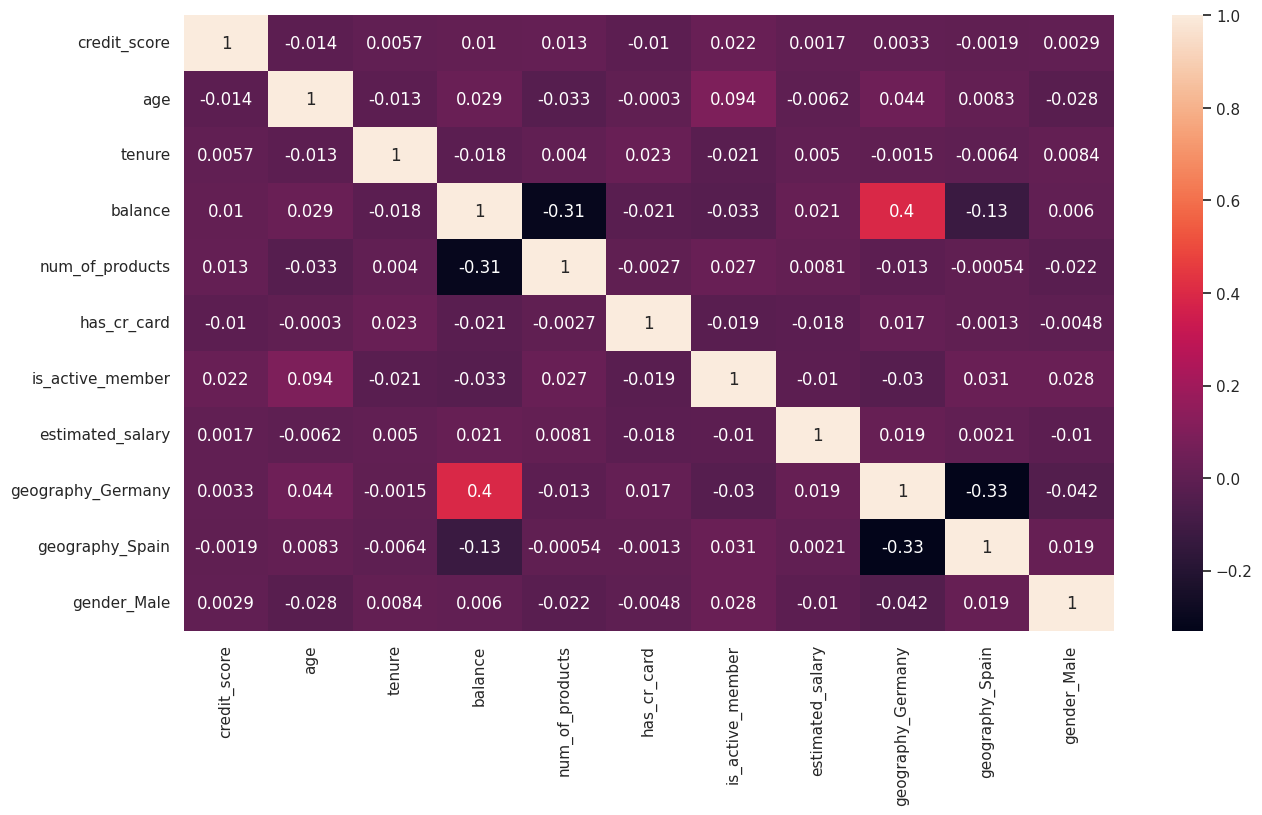

In [28]:
correlation_matrix = features_train.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(correlation_matrix, annot = True);

<div style="border:solid blue 2px; padding: 30px">
Я заполнила пропуски, удалила столбцы, не имеющие значение для нашего исследования, закодировала категориальные данные и масштабировала признаки.

## Исследование задачи

Посмотрю на баланс классов.

0    7963
1    2037
Name: exited, dtype: int64


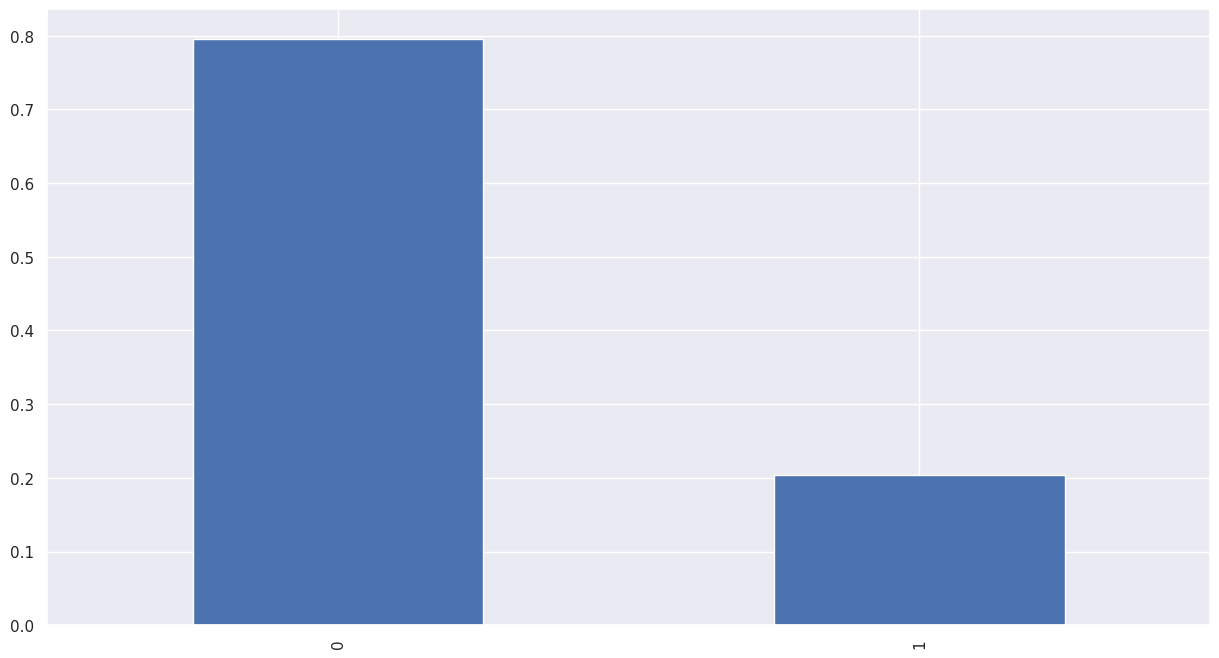

In [29]:
print(target.value_counts())
target.value_counts(normalize=True).plot(kind='bar');

**В данных наблюдается дисбаланс классов, отрицательного почти в 4 раза больше. Если мы будем прогнозировать, что никто не уйдёт из банка, то в 80% случаев мы будем правы.**

Создам модель логистической регрессии без учета дисбаланса и обучу её.

In [30]:
model_logistic_dis = LogisticRegression(random_state=12345)
model_logistic_dis.fit(features_train, target_train);

**Создам функцию для просчета метрик R2, F1 и AUC-ROC. На вход функция получает модель, признаки и целевой признак, а возвращает метрики.**

In [32]:
def print_metrics(model, features, target):
    predict = model.predict(features) # предказания модели
    proba = model.predict_proba(features)[:, 1] # вероятность положительного класса

# нахожу долю правильных ответов R2
    print('R2:', model.score(features, target))

# нахожу среднее гармоническое полноты и точности F1
    print(f'F1: {round(f1_score(target, predict), 5)}')

# нахожу значение AUC-ROC (покажет как сильно наша модель отличается от случайной)
    print(f'AUC-ROC: {round(roc_auc_score(target, proba), 5)}')

In [33]:
# посмотрим на метрики нашей модели логистической регрессии.
print_metrics(model_logistic_dis, features_valid, target_valid)

R2: 0.8025
F1: 0.3339
AUC-ROC: 0.75868


**У модели доля правильных ответов, как раз и составляет 80%, но правильно предсказывает положительный класс она в 33% случаев.**

Обучим модель случайного леса также без учета дисбаланса.

In [ ]:
model_forest_dis = RandomForestClassifier(random_state=12345)
model_forest_dis.fit(features_train, target_train)

# Узнаем метрики нашей модели решающего дерева
print_metrics(model_forest_dis, features_valid, target_valid)

R2: 0.8605
F1: 0.59031
AUC-ROC: 0.84191


**У модели случайного леса F1-мера больше на 0.23, а AUC-ROC на 0.08.**

<div style="border:solid blue 2px; padding: 30px">
На этом этапе я выяснила, что положительного класса у нас в 4 раза меньше и провела обучение двух моделей, не учитывая дисбаланс классов. Модель логистической регрессии показала плохие результаты F1, всего 0.33. А вот модель решающего дерева F1 показала лучше, но дала низкий результат AUC-ROC.

## Борьба с дисбалансом

Теперь построю модель логистической регресии, но сбалансирую классы с помощью параметра "class weight = 'balanced'".

In [ ]:
model_logistic = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345)
model_logistic.fit(features_train, target_train)

# смотрим метрики нашей модели логистической регрессии с балансом классов
print_metrics(model_logistic, features_valid, target_valid)

R2: 0.701
F1: 0.48889
AUC-ROC: 0.76347


In [ ]:
model_forest = RandomForestClassifier(class_weight='balanced', random_state=12345)
model_forest.fit(features_train, target_train)

# смотрим метрики модели решающего дерева с балансом классов
print_metrics(model_forest, features_valid, target_valid)

R2: 0.8575
F1: 0.56489
AUC-ROC: 0.84355


**F1-мера у логистической регрессии увеличилась на 0.15, а у случаного леса стала немного хуже.**


Теперь посмотрим значения метрик, увеличив положительный класс в 4 раза с помощью функции upsample.

In [ ]:
def upsample(features, target, repeat):
    # отбираю в разные переменные признаки, относящиеся к классу 0 и к классу 1
    features_zeros = features[target == 0] 
    features_ones = features[target == 1]
    # делю целевой признак по классам
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # соединяю таблицы с разными классами в общие переменные
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаю наши данные
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    # функция возвращает наши новые таблицы с признаками и целевым признаком
    return features_upsampled, target_upsampled

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)
print(features_train_upsampled.shape) # проверю размер таблицы признаков
print(target_train_upsampled.shape) # проверю размер таблицы целевого признака

(9588, 11)
(9588,)


Обучу модель на новых признаках.

In [ ]:
model_logistic_up = LogisticRegression(solver='liblinear', random_state=12345)
model_logistic_up.fit(features_train_upsampled, target_train_upsampled)

# смотрим метрики нашей модели логистической регрессии с балансом классов
print_metrics(model_logistic_up, features_valid, target_valid)

R2: 0.7005
F1: 0.4876
AUC-ROC: 0.7634


In [ ]:
model_forest_up = RandomForestClassifier(random_state=12345)
model_forest_up.fit(features_train_upsampled, target_train_upsampled)

# смотрим метрики модели решающего дерева с балансом классов
print_metrics(model_forest_up, features_valid, target_valid)

R2: 0.8495
F1: 0.59705
AUC-ROC: 0.83738


**Результат у первой модели совсем немного хуже, чем в предыдущем варианте, где мы сбалансировали вес классов с помощью параметров. А у леса F1 такой же, как при дисбалансе.**

Теперь сбалансируем, создав функцию по уменьшению отрицательного класса по тому же принципу, но здесь мы задаем значение frac.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Задаю переменной frac значение 0.25 - доля класса 0, которая нам нужна, чтобы сравняться с классом 1.


In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

# обучаю модель на новых признаках
model_logistic_down = LogisticRegression(solver='liblinear', random_state=12345)
model_logistic_down.fit(features_downsampled, target_downsampled)

# смотрим метрики нашей модели логистической регрессии с балансом классов
print_metrics(model_logistic_down, features_valid, target_valid)

R2: 0.703
F1: 0.48969
AUC-ROC: 0.7627


**Доля правильных ответов и F1 немного лучше, чем при дисбалансе классов и при увеличении положительного класса.**

In [ ]:
model_forest_down = RandomForestClassifier(random_state=12345)
model_forest_down.fit(features_downsampled, target_downsampled)

# смотрю метрики решающего дерева с балансом классов
print_metrics(model_forest_down, features_valid, target_valid)

R2: 0.7795
F1: 0.58357
AUC-ROC: 0.84454


**Доля правильных ответов ниже, чем при дисбалансе классов, но метрики стали лучше.**

Теперь найду порог классификации, при котором F1 максимально высокое.

In [ ]:
# выделю вероятность положительного класса
probabilities_one_valid = model_logistic_dis.predict_proba(features_valid)[:, 1]

# создаю переменные для сравнения с лучшими результатами
max_f1 = 0
threshold_best = 0
pre = 0
re = 0

# создаю функцию по подбору порога для максимизации F1
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > max_f1:
        max_f1 = f1
        threshold_best = threshold
        pre = precision
        re = recall

# вывод лучшего результата       
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold_best, pre, re, max_f1))

Порог = 0.26 | Точность = 0.433, Полнота = 0.589, F1 = 0.499


Сбалансирую классы по полученному порогу и посмотрим на метрики.

In [ ]:
model_logistic = LogisticRegression(class_weight={0: 0.26, 1:0.74}, solver='liblinear', random_state=12345)
model_logistic.fit(features_train, target_train)

# смотрим метрики нашей модели логистической регрессии с балансом классов
print_metrics(model_logistic, features_valid, target_valid)

R2: 0.7545
F1: 0.49949
AUC-ROC: 0.7626


**Доля правильных ответов и F1 немного лучше, чем при дисбалансе классов и при увеличении положительного класса.**

In [ ]:
# выделю вероятности положительного класса
probabilities_one_valid = model_forest_dis.predict_proba(features_valid)[:, 1]

# создам переменные для сравнения с лучшими результатами
max_f1 = 0
threshold_best = 0
pre = 0
re = 0

# создам функцию по подбору порога для максимизации F1
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > max_f1:
        max_f1 = f1
        threshold_best = threshold
        pre = precision
        re = recall

# вывожу лучший результат        
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold_best, pre, re, max_f1))

Порог = 0.30 | Точность = 0.587, Полнота = 0.663, F1 = 0.622


Сбалансирую классы по полученному порогу и посмотрим на метрики.

In [ ]:
model_forest = RandomForestClassifier(class_weight={0: 0.34, 1:0.66}, random_state=12345)
model_forest.fit(features_train, target_train)

# смотрим на метрики нашей модели логистической регрессии с балансом классов
print_metrics(model_forest, features_valid, target_valid)

R2: 0.859
F1: 0.56748
AUC-ROC: 0.83888


**Доля правильных ответов осталась такой же, а метрики стали ниже, чем при дисбалансе классов.**

<div style="border:solid blue 2px; padding: 30px">
      Доля правильно предсказанных ответов у модели логистической регрессии, учитывающей дисбаланс классов с помощью порога классификации стала на 0.05 ниже, чем с дисбалансом, но метрика F1 увеличилась с 0.33 до 0.497.

    
У леса результаты почти не отличаются с балансом и дисбалансом классов, улучшенный результат показала увеличенная выборка и cass_weight='balanced'.   
Продолжу работать с балансом классов с помощью гиперпараметра class_weight.   

### Проверка качества модели логистической регрессии, учитывая дисбаланс классов.

Подберу лучшие параметры для нашей модели, используя модуль GridSearchCV.

In [35]:
with warnings.catch_warnings():
    model_grid_logistic = GridSearchCV(
    LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345),
                param_grid = {'penalty': ('l1', 'l2', 'elasticnet'), # какие параметры подбираю
                'C': np.logspace(-4, 3, 10),
                'max_iter': range(1, 101, 5)},
    scoring=make_scorer(f1_score), # метрика, по которой будет оцениваться модель
    n_jobs=2, # параллельная оценка разных комбинаций параметров
    return_train_score=True)
    
    model_grid_logistic.fit(features_train, target_train);

In [36]:
# вывожу результаты
print(f'Лучший результат F1: {round(model_grid_logistic.best_score_, 5)}')
print('Модель для лучшего F1: {}'.format(model_grid_logistic.best_estimator_))

Лучший результат F1: 0.5072
Модель для лучшего F1: LogisticRegression(C=0.021544346900318846, class_weight='balanced', max_iter=6,
                   penalty='l1', random_state=12345, solver='liblinear')


Обучу модель логистической регресии с подобранными лучшими параметрами, учитывая дисбаланс классов.

In [ ]:
model_logistic = LogisticRegression(C=0.021544346900318846, class_weight='balanced', max_iter=6,
                   penalty='l1', random_state=12345, solver='liblinear')

model_logistic.fit(features_train, target_train);

Вывожу на экран результаты метрик логистической регресии.

In [ ]:
print('Метрики модели логистической регрессии:')
print_metrics(model_logistic, features_valid, target_valid)

Метрики модели логистической регрессии:
R2: 0.7175
F1: 0.49599
AUC-ROC: 0.76908


### Проверка качества модели решающего дерева, учитывая дисбаланс классов.

Найду лучшие параметы модели.

In [37]:
%%time

warnings.filterwarnings('ignore')

model_grid_tree = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=12345),
              param_grid = { 'criterion': ('gini', 'entropy', 'log_loss'),
                'max_depth': range (1, 11, 1),
                'min_samples_leaf': range (1, 5, 1) },
    scoring=make_scorer(f1_score),
    n_jobs=2)
    
model_grid_tree.fit(features_train, target_train);

CPU times: user 585 ms, sys: 58.9 ms, total: 644 ms
Wall time: 11.4 s


GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=2,
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': range(1, 11),
                         'min_samples_leaf': range(1, 5)},
             scoring=make_scorer(f1_score))

In [38]:
# выводим результаты
print(f'Лучший результат F1: {round(model_grid_tree.best_score_, 5)}')
print('Модель для лучшего F1: {}'.format(model_grid_tree.best_estimator_))

Лучший результат F1: 0.56306
Модель для лучшего F1: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=2, random_state=12345)


In [39]:
# обучаем модель по нашим лучшим параметрам
model_tree = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=2, random_state=12345)
model_tree.fit(features_train, target_train)
predict_valid = model_tree.predict(features_valid)

# выводим результаты метрик
print('Метрики модели решающего дерева:')
print_metrics(model_tree, features_valid, target_valid)

Метрики модели решающего дерева:
R2: 0.759
F1: 0.5642
AUC-ROC: 0.82278


### Поиск лучших параметров для модели случайного леса с помощью модуля GridSearchCV.

In [40]:
%%time

warnings.filterwarnings('ignore')

model_grid_forrest = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=12345),
    param_grid = { 'n_estimators': range (10, 101, 20),
                   'max_depth': range (1,12, 2) },
    scoring=make_scorer(f1_score),
    n_jobs=2,
    return_train_score=True)
    
model_grid_forrest.fit(features_train, target_train);

CPU times: user 1.21 s, sys: 52 ms, total: 1.26 s
Wall time: 37 s


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=2,
             param_grid={'max_depth': range(1, 12, 2),
                         'n_estimators': range(10, 101, 20)},
             return_train_score=True, scoring=make_scorer(f1_score))

In [41]:
print(f'Лучший результат F1: {round(model_grid_forrest.best_score_, 5)}')
print('Модель для лучшего F1: {}'.format(model_grid_forrest.best_estimator_))

Лучший результат F1: 0.61532
Модель для лучшего F1: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=90,
                       random_state=12345)


**Мы получили лучшую максимальную глубину 9, а количество деревьев = 90. Обучим модель с этими параметрами.**

In [42]:
model_forrest_best = RandomForestClassifier(class_weight='balanced', max_depth=9,
                       n_estimators=90, random_state=12345)
model_forrest_best.fit(features_train, target_train)
predict_valid_forrest = model_forrest_best.predict(features_valid)

print('Метрики лучшей модели случайного леса:')
print_metrics(model_forrest_best, features_valid, target_valid)

Метрики лучшей модели случайного леса:
R2: 0.8325
F1: 0.62061
AUC-ROC: 0.85401


<div style="border:solid blue 2px; padding: 30px">
Эта модель получила наилучшие метрики.

<div style="border:solid blue 2px; padding: 30px">
Я сравнила три модели. Метрики у случайного леса лучше, чем у остальных моделей.
Лучшая модель имеет максимальную глубину 9 и количество деревьев - 90.
Правильных ответов у этой модели 83%, среднее гаромоническое точности и полноты 0.62, а площадь под кривой ROC 0.85.

## Тестирование модели

Проведу финальное тестирование нашей лучшей модели на тестовой выборке.

In [43]:
predict_test_forrest = model_forrest_best.predict(features_test)
print('F1:', f1_score(target_test, predict_test_forrest))

F1: 0.6212290502793296


**Построим ROC-кривую**

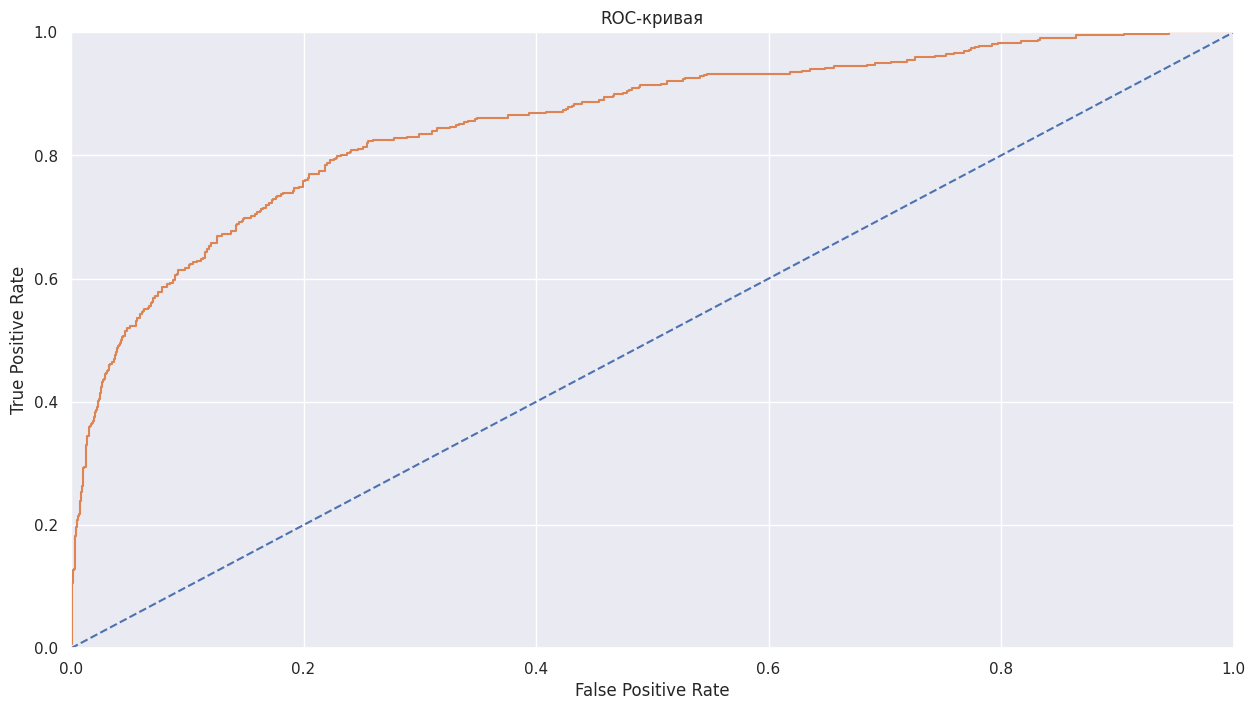

In [44]:
probabilities_one_valid = model_forrest_best.predict_proba(features_valid)[:, 1] # вероятность положительного класса

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# границы осей от 0 до 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# название осей
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# заголовок
plt.title('ROC-кривая')
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
<div class="alert alert-info">  <b>Итог исследования:<b> </div>
    
Я изучила и подготовила данные, избавившись от пропусков и ненужных данных, которые не влияют на нашу задачу - это индекс строки, фамилия и id клиента. Затем я закодировала категориальные данные - страна проживания и пол, после чего провела масштабирование признаков, чтобы модель при обучении все признаки расценивала, как равнозначные.
    
На следующем этапе я исследовала баланс классов. Отрицательный класс оказался в 4 раза больше положительного. При обучении модели без учёта дисбаланса классов я получила очень низкое значение F1-меры у логистической регрессии(0.33).
    
Затем эту же модель я обучила на сбалансированных разными методами классах. Лучшие результаты показал метод балансировки через параметр class_weight. Балансировка классов у модели случайного леса дала незначительное улучшение результатов.

В ходе исследования я сравнила три модели, подбирая для каждой лучшие гиперпараметры с помощью модуля GridSearchCV. Наилучшие результаты показала модель случайного леса. Она имеет максимальную глубину 9 и количество деревьев - 90.
Правильных ответов у нашей модели 83%, среднее гаромоническое точности и полноты 0.6206, а площадь под кривой ROC 0.85.
    
В конце нашей работы я проверила модель-победитель на тестовой выборке и получили результат F1 = 0.6212 и построили ROC-кривую этой модели.